## Initial Imports and Dataset Loading

In [0]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from datetime import datetime

# import iris dataset
from sklearn.datasets import load_iris

#import sklearn RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# load iris dataset
iris = load_iris()
iris_data = iris.data

## Random Forest **Implementation**

In [2]:
class DecisionNode:
    
    #Initialization
        
    def __init__(self, data, max_height, height = 0):
        self.data = data
        self.terminal = False
        self.max_height = max_height
        self.height = height
    
    
    #Printing for debugging
    def dataToString(self):
        print(self.data)
        
    #Split node and create child nodes
    def split(self):
        if self.height == self.max_height or len(self.data) < 10:
            self.terminal = True
            self.prediction = max(set([row[-1] for row in self.data]), key = [row[-1] for row in self.data].count)
        else:
            (group_1, group_2, self.condition, self.feature, gi) = find_best_partition(self.data)
        
            if len(group_1) == 0 or len(group_2) == 0:
                self.terminal = True
                self.prediction = max(set([row[-1] for row in self.data]), key = [row[-1] for row in self.data].count)
            else:
                self.left = DecisionNode(group_1, self.max_height, self.height + 1)
                self.right = DecisionNode(group_2, self.max_height, self.height + 1)
                self.left.split()
                self.right.split()
    
    def predict(self, test_data):
        if self.terminal == True:
            return self.prediction
        else:     
            if isinstance(test_data[self.feature], str):
                if test_data[self.feature] == self.condition:
                    return self.left.predict(test_data)
                else:
                    return self.right.predict(test_data)
            else:
                if test_data[self.feature] <= self.condition:
                    return self.left.predict(test_data)
                else:
                    return self.right.predict(test_data)

#Partitions data depending on condition
def partition(data, feature, condition):
    group_1 = [];
    group_2 = [];
    
    if isinstance(data[0][feature], str):
        for row in data:
            if row[feature] == condition:
                group_1.append(row)
            else:
                group_2.append(row)
    else:
        for row in data:
            if row[feature] <= condition:
                group_1.append(row)
            else:
                group_2.append(row)
    return group_1, group_2


#calculates Gini score of a group
def gini_score(data):
    classifications = [row[-1] for row in data]
    num = len(classifications)
    if num == 0:
        return 1
    conditions = list(set(classifications))
    sum_ = 0
    for i in conditions:
        proportion = classifications.count(i)/num
        sum_ = sum_ + proportion * (1 - proportion)
    return sum_


#find the best split
def find_best_partition(data):
    best_gini = 999;
    
    found = False
    for i in range(len(data[0])-1):
        possible_conditions = list(set([row[i] for row in data]))
        for j in possible_conditions:
            (group_1, group_2) = partition(data, i, j)
            #if len(group_1) == 0 or len(group_2) == 0:
            #    continue
            
            if len(group_1) < 10 or len(group_2) < 10:
                continue
            
            
            gini = gini_score(group_1) * len(group_1)/len(data) + gini_score(group_2) * len(group_2)/len(data)
            if gini < best_gini:
                found = True
                best_gini = gini
                best_group_1 = group_1
                best_group_2 = group_2
                best_condition = j
                best_feature = i
    if found == False:
        best_condition = 1
        best_feature = 1
        best_group_1 = data
        best_group_2 = []
    return (best_group_1, best_group_2, best_condition, best_feature, best_gini)

def build_tree(data, max_depth, min_size):
    root = DecisionNode(data, max_depth)
    root.split()
    return root

class RFDecisionNode:
    
    #Initialization
        
    def __init__(self, data, max_height, n_features, height = 0,):
        self.data = data
        self.terminal = False
        self.max_height = max_height
        self.height = height
        self.n_features = n_features
    
    
    #Printing for debugging
    def dataToString(self):
        print(self.data)
        
    #Split node and create child nodes
    def split(self):
        if self.height == self.max_height or len(self.data) < 10:
            self.terminal = True
            self.prediction = max(set([row[-1] for row in self.data]), key = [row[-1] for row in self.data].count)
        else:
            (group_1, group_2, self.condition, self.feature, gi) = RF_find_best_partition(self.data, self.n_features)

            if len(group_1) == 0 or len(group_2) == 0:
                self.terminal = True
                self.prediction = max(set([row[-1] for row in self.data]), key = [row[-1] for row in self.data].count)
            else:
                self.left = RFDecisionNode(group_1, self.max_height, self.n_features , self.height + 1)
                self.right = RFDecisionNode(group_2, self.max_height, self.n_features, self.height + 1)
                self.left.split()
                self.right.split()

    
    def predict(self, test_data):
        if self.terminal == True:
            return self.prediction
        else:     
            if isinstance(test_data[self.feature], str):
                if test_data[self.feature] == self.condition:
                    return self.left.predict(test_data)
                else:
                    return self.right.predict(test_data)
            else:
                if test_data[self.feature] <= self.condition:
                    return self.left.predict(test_data)
                else:
                    return self.right.predict(test_data)
                

class RF:
    def __init__(self, data, max_height, n_features, n_trees, n_bagging):
        self.data = data
        self.max_height = max_height
        self.n_features = n_features
        self.n_trees = n_trees
        self.n_bagging = n_bagging
         
    def RF_build_tree(self, dat):
        root = RFDecisionNode(dat, self.max_height, self.n_features)
        root.split()
        return root
    
    def create_model(self):
        self.forest = [];
        for i in range(self.n_trees):
            chosen_input = random.sample(list(range(0, len(self.data))), self.n_bagging)
            bag = [];
            for j in chosen_input:
                bag.append(self.data[j])
            
            temp = self.RF_build_tree(bag)
            self.forest.append(temp)

    
    def predict(self, test_data):
        temp_result = [];
        for tree in self.forest:
            temp_result.append(tree.predict(test_data))
        return max(set(temp_result), key = temp_result.count)

#find the best split
def RF_find_best_partition(data, n_features):
    best_gini = 999;
    
    
    #Choose random features
    chosen_features = random.sample(list(range(0, len(data[0])-1)), n_features)
    
    found = False;
    
    for i in chosen_features:
        possible_conditions = list(set([row[i] for row in data]))
        
        for j in possible_conditions:
            (group_1, group_2) = partition(data, i, j)
            if len(group_1) < 10 or len(group_2) < 10:
                continue
            #if len(group_1) == 0 or len(group_2) == 0:
            #    continue
            
            gini = gini_score(group_1) * len(group_1)/len(data) + gini_score(group_2) * len(group_2)/len(data)
            if gini < best_gini:
                found = True;
                best_gini = gini
                best_group_1 = group_1
                best_group_2 = group_2
                best_condition = j
                best_feature = i
    if found == False:
        best_condition = 1
        best_feature = 1
        best_group_1 = data
        best_group_2 = []
    return (best_group_1, best_group_2, best_condition, best_feature, best_gini)


## Test
training_set = [];
test_set = [];

for row in iris_data:
    if random.random() < 0.7:
        training_set.append(row)
    else:
        test_set.append(row)

startTime = datetime.now()
dec_tree = build_tree(training_set, 5, 20)
print(datetime.now() - startTime)

test_set_no_label = np.delete(test_set, -1, axis = 1)
test_set_labels = np.array(test_set)[:,-1]
results = [];

for row in test_set_no_label:
    results.append(dec_tree.predict(row))

results = np.array(results)

count = 0
for i in range(len(results)):
    if results[i] == test_set_labels[i]:
        count += 1

accuracy = count/len(results)
print(accuracy)

startTime = datetime.now()
randForest = RF(training_set, 5, 4, 50, 500)
randForest.create_model()
print(datetime.now() - startTime)

results = []

for row in test_set_no_label:
    results.append(randForest.predict(row))

results = np.array(results)

count = 0
for i in range(len(results)):
    if results[i] == test_set_labels[i]:
        count += 1

accuracy = count/len(results)
print(accuracy)

0:00:00.016992
0.3181818181818182


ValueError: ignored

## sklearn RandomForestClassifier results

RandomForest with 30 estimators with features [0, 1] has a score of 0.9266666666666666
RandomForest with 30 estimators with features [0, 2] has a score of 0.9933333333333333
RandomForest with 30 estimators with features [2, 3] has a score of 0.9933333333333333


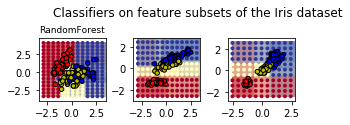

In [3]:
# from sklearn.datasets import make_blobs
# from sklearn.model_selection import cross_val_score

# Parameters
n_classes = 3
n_estimators = 30
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration

plot_idx = 1

models = [RandomForestClassifier(n_estimators=n_estimators)]

for pair in ([0, 1], [0, 2], [2, 3]):
    for model in models:
        # We only take the two corresponding features
        X = iris.data[:, pair]
        y = iris.target

        # Shuffle
        idx = np.arange(X.shape[0])
        np.random.seed(RANDOM_SEED)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Standardize
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std

        # Train
        model.fit(X, y)

        scores = model.score(X, y)
        # Create a title for each column and the console by using str() and
        # slicing away useless parts of the string
        model_title = str(type(model)).split(
            ".")[-1][:-2][:-len("Classifier")]

        model_details = model_title
        if hasattr(model, "estimators_"):
            model_details += " with {} estimators".format(
                len(model.estimators_))
        print(model_details + " with features", pair,
              "has a score of", scores)

        plt.subplot(3, 4, plot_idx)
        if plot_idx <= len(models):
            # Add a title at the top of each column
            plt.title(model_title, fontsize=9)

        # Now plot the decision boundary using a fine mesh as input to a
        # filled contour plot
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        # Choose alpha blend level with respect to the number
        # of estimators
        # that are in use (noting that AdaBoost can use fewer estimators
        # than its maximum if it achieves a good enough fit early on)
        estimator_alpha = 1.0 / len(model.estimators_)
        for tree in model.estimators_:
            Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a
        # black outline
        xx_coarser, yy_coarser = np.meshgrid(
            np.arange(x_min, x_max, plot_step_coarser),
            np.arange(y_min, y_max, plot_step_coarser))
        Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(),
                                         yy_coarser.ravel()]
                                         ).reshape(xx_coarser.shape)
        cs_points = plt.scatter(xx_coarser, yy_coarser, s=15,
                                c=Z_points_coarser, cmap=cmap,
                                edgecolors="none")

        # Plot the training points, these are clustered together and have a
        # black outline
        plt.scatter(X[:, 0], X[:, 1], c=y,
                    cmap=ListedColormap(['r', 'y', 'b']),
                    edgecolor='k', s=20)
        plot_idx += 1  # move on to the next plot in sequence

plt.suptitle("Classifiers on feature subsets of the Iris dataset", fontsize=12)
plt.axis("tight")
plt.tight_layout(h_pad=0.2, w_pad=0.2, pad=2.5)
plt.show()